# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
# Import libraries
import torch
from torch import nn, optim

import torchvision
from torchvision import datasets, models, transforms

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from PIL import Image
import numpy as np
import copy
import json
import os
import time

In [2]:
# Detect if there's a GPU available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Training on {}...'.format(device))

Training on cpu...


In [18]:
print(torch.__version__)

1.0.0


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). You can [download the data here](https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip). The dataset is split into two parts, training and validation. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. If you use a pre-trained network, you'll also need to make sure the input data is resized to 224x224 pixels as required by the networks.

The validation set is used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks available from `torchvision` were trained on the ImageNet dataset where each color channel was normalized separately. For both sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.

In [3]:
## DATASET TRANSFORMS ##
# normalize color channel -  mean
input_mean = [0.485, 0.456, 0.406]

# Normalize color channel - standard deviation
input_sdev = [0.229, 0.224, 0.225]

# random rotation
input_rrot = 30

# resize
input_resize = 256

# crop size
input_size = 224


## DATALOADER SETTINGS ##
# Number of epochs
num_epochs = 13

# Batch size 
batch_size = {'train':12,'valid':12}

# Number of subprocesses
num_workers = 4

# Shuffle at every epoch flag
shuffle_epoch = True


## GENERAL SETTINGS ##
# Main data folder
data_dir = 'flower_data'

# Feature extracting flag: True, update the reshaped layer params; False, finetune the whole model.
feature_extract = False

In [4]:
# Define transforms for the training and validation sets
data_transforms = {
                    'train': transforms.Compose([
                                                transforms.RandomRotation(degrees=input_rrot),
                                                transforms.RandomResizedCrop(input_size),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                transforms.Normalize(input_mean, input_sdev)
                                                ]),
                    'valid': transforms.Compose([
                                                transforms.Resize(input_resize),
                                                transforms.CenterCrop(input_size),
                                                transforms.ToTensor(),
                                                transforms.Normalize(input_mean, input_sdev)
                                                ]),
                  }

# Load and transform datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train',
                                                                                                   'valid']}

# Define dataloaders
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size[x],
                                                                 shuffle=shuffle_epoch,
                                                                 num_workers=num_workers) for x in ['train',
                                                                                                    'valid']}

# Train dataset classes number
num_classes = len(image_datasets['train'].classes)

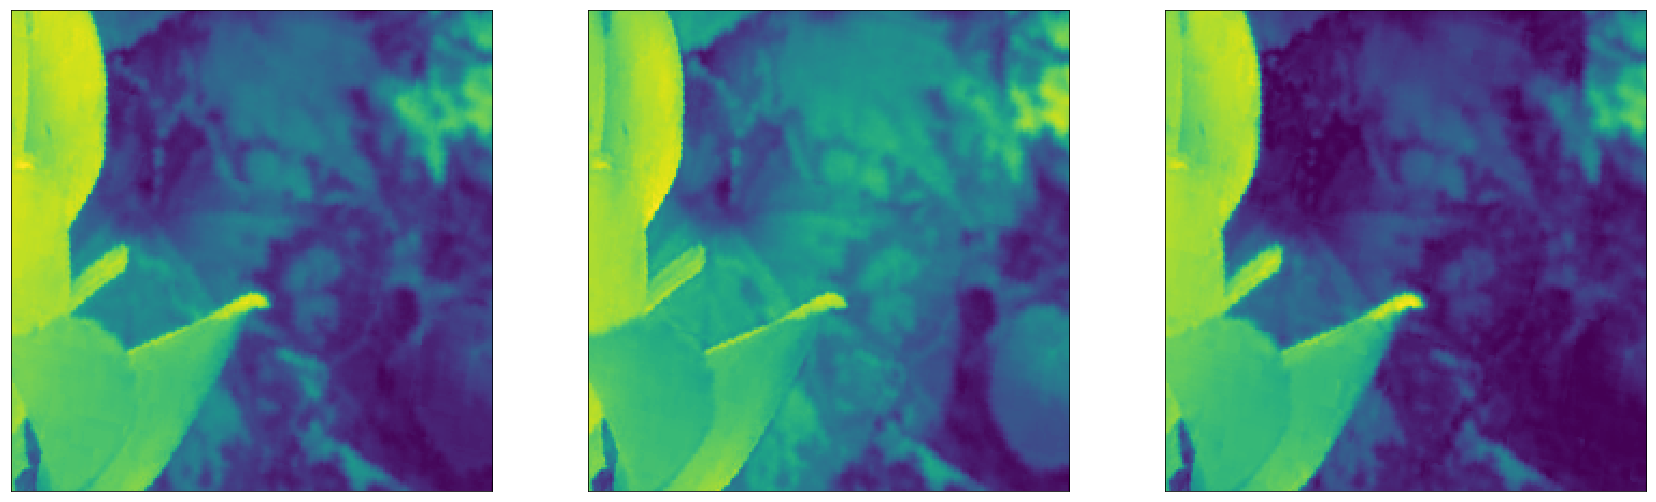

In [5]:
## Show sample data
# Iterate train data loader and get sample
images, classes = next(iter(data_loaders['train']))
images = images[0].numpy()

# Plot sample for every channel
fig = plt.figure(figsize=(50, 50))
for ch in np.arange(len(images)):
    ax = fig.add_subplot(1, 5, ch+1, xticks=[], yticks=[])
    ax.imshow(images[ch])

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [6]:
# Get classes name
with open('cat_to_name.json', 'r') as f:
    classes_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [7]:
# Function: Feature extract
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [10]:
# Function: Initialize model
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    
    # Define model architecture
    model_dp = None
    model_dp = models.densenet201(pretrained=use_pretrained)
    
    # Set parameters for feature extract
    set_parameter_requires_grad(model_dp, feature_extract)
    
    # Get model input number, dataset classes number and apply data linear transformation
    model_ftrs = model_dp.classifier.in_features
    model_dp.classifier = nn.Linear(model_ftrs, num_classes)
    
    return model_dp

In [11]:
# Function: Optimizer, stochastic gradient descent
def optimize_model(model, feature_extract):
    # Send model to available device
    model_dp = model.to(device)

    # Gather parameters to optimize
    params_to_update = model_dp.parameters()

    # Update all parameters
    if feature_extract:
        params_to_update = []
        for name,param in model_dp.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)

    return model_dp, optim.SGD(params_to_update, lr=0.001, momentum=0.9)

In [12]:
# Function: Train model
def train_model(model, dataloaders, optimizer, num_epochs=num_epochs):
    # Set start time
    since = time.time()

    # Set variables to get historical and best accuracy
    val_acc_history = []
    train_acc_history = []
    val_best_acc = 0.0
    train_best_acc = 0.0
    
    # Set loss function
    criterion = nn.CrossEntropyLoss()

    # Get whole parameters and persistent buffers from the module
    best_model_wts = copy.deepcopy(model.state_dict())

    # Iterate over model
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Define iterate way depending the phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                # Set module to training mode
                model.train()
            else:
                # Set module to evaluation mode
                model.eval()

            # Set variables to measure running accuracy
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for images, classes in dataloaders[phase]:
                # Send images and classes to available device
                images = images.to(device)
                classes = classes.to(device)

                # Clear the gradients of all optimized tensors
                optimizer.zero_grad()

                ## Forward
                # Track history only in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    # Send images to model
                    outputs = model(images)
                    # Balance train set with loss function (LogSoftmax and NLLLoss)
                    loss = criterion(outputs, classes)
                    # Get maximum values from tensor, reduce dimension and store previous output
                    _, preds = torch.max(outputs, 1)

                    # Backward and optimize in training phase
                    if phase == 'train':
                        # Accumulate current tensor gradient
                        loss.backward()
                        # Update parameters
                        optimizer.step()

                # Get running statistics
                running_loss += loss.item() * images.size(0)
                running_corrects += torch.sum(preds == classes.data)

            # Get epoch loss and accuracy
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Copy whole parameters and persistent buffers from best module
            if phase == 'valid' and epoch_acc > val_best_acc:
                val_best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            elif phase == 'train' and epoch_acc > train_best_acc:
                train_best_acc = epoch_acc
                
            # Get historical accuracy
            if phase == 'valid':
                val_acc_history.append([phase, epoch, epoch_loss, epoch_acc])
            elif phase == 'train':
                train_acc_history.append([phase, epoch, epoch_loss, epoch_acc])
                
        print()

    # Set stop time and measure time elapsed
    time_elapsed = time.time() - since
    
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best train Acc: {:4f}'.format(train_best_acc))
    print('Best valid Acc: {:4f}'.format(val_best_acc))

    # Load best model parameters and persistent buffers
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history

In [13]:
# Initialize model
model_dp = initialize_model(num_classes, feature_extract, use_pretrained=True)

# Optimize model
model_dp, optimizer_dp = optimize_model(model_dp, feature_extract)

/home/giancastrok/anaconda3/lib/python3.7/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [14]:
# Train and evaluate model
model_dp, train_hist, val_hist = train_model(model_dp, data_loaders, optimizer_dp)

Epoch 0/12
----------
train Loss: 2.5032 Acc: 0.4815
valid Loss: 0.5287 Acc: 0.8961

Epoch 1/12
----------
train Loss: 0.8170 Acc: 0.8404
valid Loss: 0.1862 Acc: 0.9621

Epoch 2/12
----------
train Loss: 0.4901 Acc: 0.9026
valid Loss: 0.1253 Acc: 0.9743

Epoch 3/12
----------
train Loss: 0.3740 Acc: 0.9199
valid Loss: 0.0919 Acc: 0.9829

Epoch 4/12
----------
train Loss: 0.3038 Acc: 0.9364
valid Loss: 0.0849 Acc: 0.9792

Epoch 5/12
----------
train Loss: 0.2563 Acc: 0.9454
valid Loss: 0.0820 Acc: 0.9792

Epoch 6/12
----------
train Loss: 0.2193 Acc: 0.9505
valid Loss: 0.0668 Acc: 0.9841

Epoch 7/12
----------
train Loss: 0.2105 Acc: 0.9527
valid Loss: 0.0681 Acc: 0.9780

Epoch 8/12
----------
train Loss: 0.1731 Acc: 0.9626
valid Loss: 0.0817 Acc: 0.9792

Epoch 9/12
----------
train Loss: 0.1700 Acc: 0.9631
valid Loss: 0.0585 Acc: 0.9866

Epoch 10/12
----------
train Loss: 0.1464 Acc: 0.9673
valid Loss: 0.0510 Acc: 0.9878

Epoch 11/12
----------
train Loss: 0.1541 Acc: 0.9654
valid Loss

## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [17]:
# Get idx from classes
model_dp.class_to_idx = image_datasets['train'].class_to_idx

# Save the checkpoint 
torch.save(
           {
            'model': 'densenet201', 
            'classifier': model_dp.classifier,
            'classes_idx': model_dp.class_to_idx,
            'state_dict': model_dp.state_dict(),
            'optimizer_dict':optimizer_dp.state_dict(), 
            'epoch': num_epochs,
            'batch_size': batch_size
           }, 
            'giancp.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [16]:
# Function: Load model
def load_model(checkpoint_path):
    
    cp = torch.load(checkpoint_path, map_location='cpu')
    model = models.densenet201(pretrained=True)
    
    # Freeze parameters that we don't need to re-train 
    for param in model.parameters():
        param.requires_grad = False
    
    # Set model info 
    model.classifier = cp['classifier']
    model.class_to_idx = cp['class_idx']
    model.load_state_dict(cp['state_dict'])

    return model

In [17]:
# Load checkpoint and rebuild the model

model_loaded = load_model('checkpoint.pth')

/anaconda3/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [ ]:
torch.load('checkpoint.pth', map_location='cpu')

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [23]:
def process_image(image):
    # Open image
    img = Image.open(image)
    
    # Define image transforms
    preprocess = transforms.Compose([transforms.Resize(input_resize), 
                                     transforms.CenterCrop(input_size),
                                     transforms.ToTensor(),
                                     transforms.Normalize(input_mean, input_sdev)])
    
    # Transform image
    img_tensor = preprocess(img)
    
    # Resize image dimension 
    img_tensor.unsqueeze_(0)
    
    return img_tensor

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [36]:
def imgshow(image):
    
    # Add subsplots
    fig, ax = plt.subplots()
    
    # Transpose tensor
    img = image.transpose((1, 2, 0))
    
    # Normalize color channel
    mean = np.array(input_mean)
    std = np.array(input_sdev)
    img = std * img + mean
    
    # Clip image
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

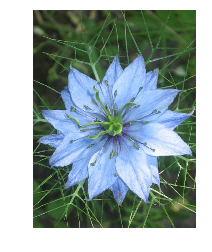

In [37]:
# Check reading image
img_path = 'flower_data/train/33/image_06442.jpg'
img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [28]:
def predict(image_path, model, topk=5, device='cuda'):
    # Send model to available device 
    model.to(device)
    model.eval()
    
    # Load image and send to available device
    img = process_image(image_path)
    img = img.to(device)
    
    # Get model output data
    output = nn.functional.log_softmax(model.forward(img), dim=1)

    # Get idx from classes 
    idx_to_class = dict((v,k) for k, v in model.class_to_idx.items())
    
    # Get probabilities
    pobabilities = torch.exp(output).data.cpu().numpy()[0]

    # Get top probabilities
    top_idx = np.argsort(pobabilities)[-topk:][::-1] 
    top_classes = [idx_to_class[x] for x in top_idx]
    top_probabilities = pobabilities[top_idx]
    
    return top_probabilities, top_classes

In [29]:
probabilities, classes = predict(img_path, model_loaded)
print(probabilities)
print(classes)

[9.9987411e-01 9.9194054e-05 1.1147302e-05 3.5170999e-06 1.9358104e-06]
['33', '28', '35', '19', '9']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the validation accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

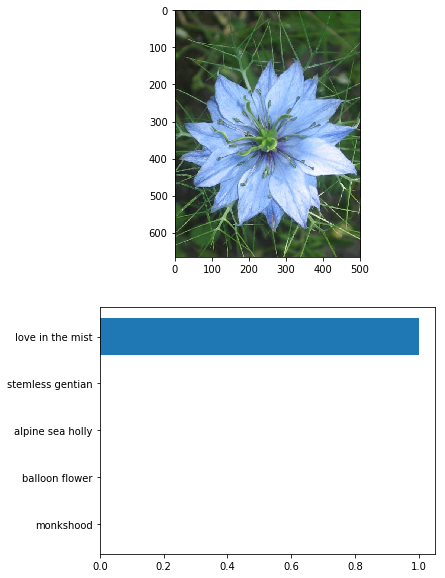

In [45]:
# Add subsplots
fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)

# Set image to plot
ax1.imshow(img)

# Set probability and class name axis
y_pos = np.arange(len(probabilities))
ax2.barh(y_pos, probabilities)
ax2.set_yticks(y_pos)
ax2.set_yticklabels([classes_name[x] for x in classes])
ax2.invert_yaxis()